# Pruebas datos crudos sensor

## Importar datos

- Esto guarda cada archivo CSV en un diccionario dataframes, donde la clave es el nombre del archivo y el valor es su DataFrame correspondiente.
- Puedes acceder a cualquier CSV con dataframes["nombre_del_archivo_sin_extension"].

In [39]:
import pandas as pd
import glob
import os

folder_path = r"C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos crudos"

# Busca todos los archivos CSV en la carpeta
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

# Crear un diccionario con los DataFrames, usando el nombre del archivo sin extensión como clave
dataframes = {os.path.basename(file).replace('.csv', ''): pd.read_csv(file, delimiter=";") for file in csv_files}

# Mostrar los nombres de los archivos cargados
print("Archivos cargados:", list(dataframes.keys()))

# Acceder a un DataFrame específico, por ejemplo:
nombre_archivo = "raw_data_95_77"  # Cambia esto por el nombre del archivo sin ".csv"
df = dataframes[nombre_archivo]
df


Archivos cargados: ['raw_data_92_103_deporte', 'raw_data_95_77', 'raw_data_95_83', 'raw_data_95_87_apnea', 'raw_data_96_74_papa']


,Tiempo (ms),IR,AMB_IR,RED,AMB_RED
0,0,0,0,63493,0
1,0,0,0,63493,438
2,1,31262,0,63493,438
3,1,31262,448,63493,438
4,2,31262,448,64243,438
...,...,...,...,...,...
12920,29998,33677,353,3033,379
12921,29999,33677,353,2951,379
12922,29999,33677,353,2951,309
12923,29999,33590,353,2951,309


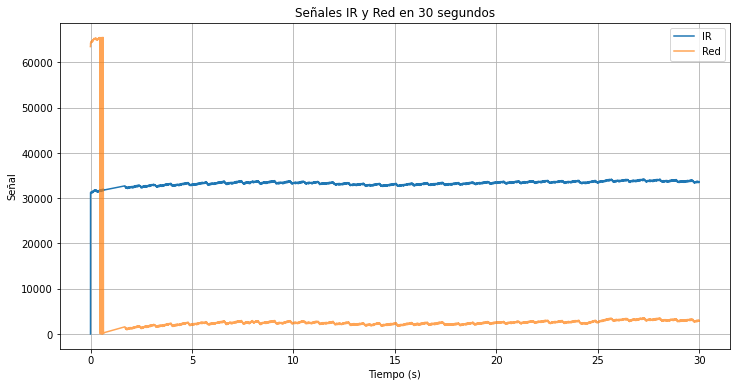

In [40]:
# Convertir el tiempo de milisegundos a segundos
df["Tiempo (ms)"] = df["Tiempo (ms)"] / 1000  # Ahora el tiempo está en segundos

# Filtrar hasta los 30 segundos
df_filtrado = df[df["Tiempo (ms)"] <= 30]

# Graficar con la escala correcta
plt.figure(figsize=(12, 6))
plt.plot(df_filtrado["Tiempo (ms)"], df_filtrado["IR"], label="IR")
plt.plot(df_filtrado["Tiempo (ms)"], df_filtrado["RED"], label="Red", alpha=0.7)
plt.xlabel("Tiempo (s)")
plt.ylabel("Señal")
plt.title("Señales IR y Red en 30 segundos")
plt.legend()
plt.grid()
plt.show()


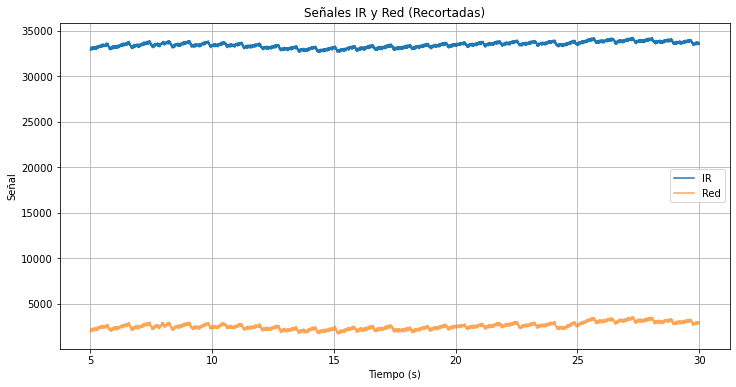

In [43]:
# Filtrar los primeros segundos para evitar valores extremos
df_recortado = df[df["Tiempo (ms)"] > 5]  # Ignoramos los primeros 5 segundos

# Graficar de nuevo con zoom
plt.figure(figsize=(12, 6))
plt.plot(df_recortado["Tiempo (ms)"], df_recortado["IR"], label="IR")
plt.plot(df_recortado["Tiempo (ms)"], df_recortado["RED"], label="Red", alpha=0.7)
plt.xlabel("Tiempo (s)")
plt.ylabel("Señal")
plt.title("Señales IR y Red (Recortadas)")
plt.legend()
plt.grid()
plt.show()

### Filtro paso-bajo Butterworth

In [45]:
from scipy.signal import butter, filtfilt

# Función para aplicar filtro pasa-bajos
def butter_lowpass_filter(data, cutoff=2.0, fs=60, order=3):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

# Aplicamos el filtro a las señales IR y RED
df_filtrado["IR_filtrado"] = butter_lowpass_filter(df_filtrado["IR"])
df_filtrado["RED_filtrado"] = butter_lowpass_filter(df_filtrado["RED"])


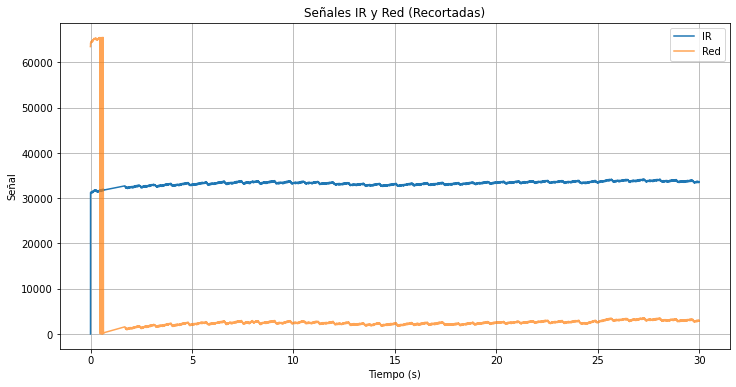

In [46]:
plt.figure(figsize=(12, 6))
plt.plot(df_filtrado["Tiempo (ms)"], df_filtrado["IR"], label="IR")
plt.plot(df_filtrado["Tiempo (ms)"], df_filtrado["RED"], label="Red", alpha=0.7)
plt.xlabel("Tiempo (s)")
plt.ylabel("Señal")
plt.title("Señales IR y Red (Recortadas)")
plt.legend()
plt.grid()
plt.show()

In [49]:
# Calcular la frecuencia de muestreo a partir de los datos
df_filtrado["Delta_t"] = df_filtrado["Tiempo (ms)"].diff()  # Diferencia de tiempos consecutivos
fs = 1000 / df_filtrado["Delta_t"].median()  # Convertimos de ms a Hz

print(f"Frecuencia de muestreo estimada: {fs:.2f} Hz")


Frecuencia de muestreo estimada: 1000000.00 Hz


In [50]:
from scipy.signal import find_peaks

# Encontrar picos en la señal IR filtrada
peaks, _ = find_peaks(df_filtrado["IR_filtrado"], distance=fs//2)  # Espaciado mínimo entre picos (medio segundo)

# Calcular la frecuencia cardíaca en pulsaciones por minuto (BPM)
num_picos = len(peaks)
duracion_min = (df_filtrado["Tiempo (ms)"].iloc[-1] - df_filtrado["Tiempo (ms)"].iloc[0]) / 60
frecuencia_cardiaca = num_picos / duracion_min  

print(f"Frecuencia cardíaca estimada: {frecuencia_cardiaca:.2f} BPM")


Frecuencia cardíaca estimada: 2.00 BPM


In [48]:
# Cálculo de la Relación de Absorción (R)
r = (df_filtrado["RED_filtrado"].mean() / df_filtrado["IR_filtrado"].mean())

# Fórmula empírica para SpO2
spo2 = 110 - 25 * r  

print(f"Saturación de oxígeno estimada: {spo2:.2f}%")


Saturación de oxígeno estimada: 107.24%


In [51]:
print(df_filtrado[["Tiempo (ms)"]].head(10))  # Muestra los primeros 10 valores de tiempo
print(df_filtrado["Delta_t"].describe())  # Estadísticas de los intervalos de tiempo


   Tiempo (ms)
0        0.000
1        0.000
2        0.001
3        0.001
4        0.002
5        0.002
6        0.013
7        0.013
8        0.014
9        0.014
count    12924.000000
mean         0.002321
std          0.009895
min          0.000000
25%          0.000000
50%          0.001000
75%          0.001000
max          1.035000
Name: Delta_t, dtype: float64


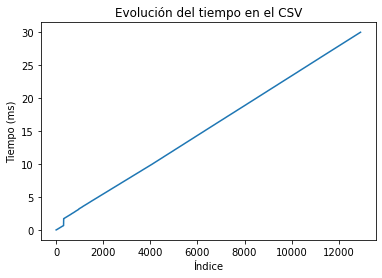

In [52]:
plt.plot(df_filtrado["Tiempo (ms)"])
plt.xlabel("Índice")
plt.ylabel("Tiempo (ms)")
plt.title("Evolución del tiempo en el CSV")
plt.show()


In [53]:
df_filtrado["Tiempo corregido"] = df_filtrado.index / 60  # Suponiendo 60 Hz


In [54]:
fs_estimada = df_filtrado["Delta_t"].mode()[0]  # Tomamos el valor más común
fs = 1000 / fs_estimada  # Convertimos de ms a Hz
print(f"Frecuencia de muestreo corregida: {fs:.2f} Hz")


Frecuencia de muestreo corregida: inf Hz


<ipython-input-54-a83a9905d97b>:2: RuntimeWarning: divide by zero encountered in double_scalars
  fs = 1000 / fs_estimada  # Convertimos de ms a Hz
